In [1]:
import freud
import gsd
import gsd.pygsd
import gsd.hoomd
import signac
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cycler
from scipy.stats import linregress
import cycler
from matplotlib.lines import Line2D

In [2]:
project = signac.get_project("pcbm-project")

In [3]:
def atom_type_pos(snap, atom_type):
    if not isinstance(atom_type, list):
        atom_type = [atom_type]
    positions = []
    for atom in atom_type:
        indices = np.where(snap.particles.typeid == snap.particles.types.index(atom))
        positions.append(snap.particles.position[indices])
    return np.concatenate(positions)
def msd_slope(job, step_size = 2, atom_types='all'):  
    msd = np.genfromtxt(job.fn('msd.log'), names=True, delimiter="\t")
    x = msd['timestep'][-3000::step_size]
    y = msd[atom_types][-3000::step_size]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return x, y, slope

In [6]:
#constant density of msd.log
def msd_constant_density(density, temp_min, temp_max, polymer_length=None):
    state_dict = {"size": "small",
                  "process": "quench",
                  "density":density,
                  "molecule":"PTB7_{}mer_smiles"}
    if polymer_length:
        state_dict["molecule"] = "PTB7_{}mer_smiles".format(polymer_length)
    job_list = project.find_jobs(state_dict)
    slope_values = []
    fig = plt.figure()
    ax = plt.subplot(111)
    for job in job_list:
        if temp_min <= job.sp['kT_reduced'] <= temp_max:
            x, y, slope = msd_slope(job)
            ax.plot(x, y, label=job.sp['kT_reduced'])
            slope_values.append(slope)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    plt.title("MSD of PTB7 temperatures at %sden" % (job.sp['density']))
    plt.xlabel("timestep", fontsize=14)
    plt.ylabel("msd", fontsize=14)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    handles,labels = ax.get_legend_handles_labels()
    as_float = [float(i) for i in labels]
    order = np.argsort(as_float)
    handles = [handles[i] for i in order]
    labels = [labels[i] for i in order]
    ax.legend(handles,labels,loc=2)
    plt.show()

#constant temperature of msd.log
def msd_constant_temperature(kT_reduced, den_min, den_max, polymer_length=None):
    state_dict = {"size": "small",
                  "process": "quench",
                  "kT_reduced":kT_reduced,
                  "molecule":"PTB7_{}mer_smiles"}
    if polymer_length:
        state_dict["molecule"] = "PTB7_{}mer_smiles".format(polymer_length)
    job_list = project.find_jobs(state_dict)
    slope_values = []
    fig = plt.figure()
    ax = plt.subplot(111)
    for job in job_list:
        if den_min <= job.sp['density'] <= den_max:
            x, y, slope = msd_slope(job)
            ax.plot(x, y, label=job.sp['density'])
            slope_values.append(slope)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    plt.title("MSD of PTB7 densities at %skT" % (job.sp['kT_reduced']))
    plt.xlabel("timestep", fontsize=14)
    plt.ylabel("msd", fontsize=14)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    handles,labels = ax.get_legend_handles_labels()
    as_float = [float(i) for i in labels]
    order = np.argsort(as_float)
    handles = [handles[i] for i in order]
    labels = [labels[i] for i in order]
    ax.legend(handles,labels,loc=2)
    plt.show()
    
def msd_from_gsd(gsdfile, start=-30, stop=-1, atom_type='all', msd_mode = "window"):
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    positions = []
    for frame in trajectory[start:stop]:
        if atom_type == 'all':
            atom_positions = frame.particles.position[:]
        else:
            atom_positions = atom_type_pos(frame, atom_type)
        positions.append(atom_positions)
    msd = freud.msd.MSD(box=trajectory[-1].configuration.box, mode=msd_mode)
    msd.compute(positions)
    f.close()
    return(msd.msd) # This is retruning an array of numbers (the y-axis on the msd plot)

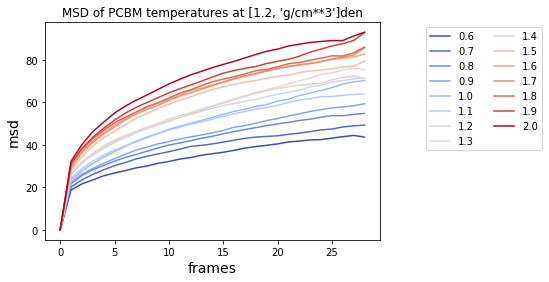

In [14]:
state_dict={"density":[1.2,'g/cm**3'], "tau":0.03}
state_dict['density.$lt'] = 1.3, 'g/cm**3'


job_list = project.find_jobs(state_dict)
fig = plt.figure()
ax = plt.subplot(111)
color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for kT,job in job_list.groupby('kT_reduced'):
    job = list(job)[0]
    msd = msd_from_gsd(job.fn('trajectory.gsd'), atom_type='all')
    y = msd
    tspf = job.sp['n_steps'] / 100
    x = range(len(y))
    plt.plot(x, y, label=kT)
plt.title("MSD of PCBM temperatures at %sden" % (job.sp['density']))
plt.xlabel("frames", fontsize=14)
plt.ylabel("msd", fontsize=14)
plt.legend( bbox_to_anchor=(1.5, 1), ncol=2)
plt.show()